In [1]:
import scikitplot as skplt
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import nltk
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
reviews = pd.read_csv('sample30.csv')
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
reviews.shape

(30000, 15)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
reviews.isna().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [6]:
(reviews.isna().sum()/len(reviews))*100

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

In [7]:
df = reviews[['brand', 'manufacturer', 'reviews_didPurchase', 'reviews_rating', 'reviews_text', 'user_sentiment']]

In [8]:
df.isna().sum()

brand                      0
manufacturer             141
reviews_didPurchase    14068
reviews_rating             0
reviews_text               0
user_sentiment             1
dtype: int64

In [9]:
df['reviews_didPurchase'] = df['reviews_didPurchase'].fillna('Not Available')

<ipython-input-9-0243b47cb43f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews_didPurchase'] = df['reviews_didPurchase'].fillna('Not Available')


In [10]:
df = df.dropna()

In [11]:
data = df['reviews_rating'].value_counts()

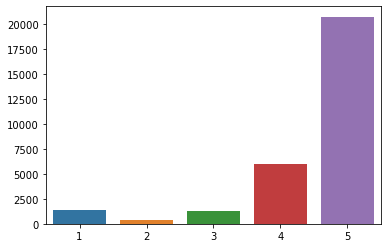

In [12]:
sns.barplot(x=data.index, y=data.values)

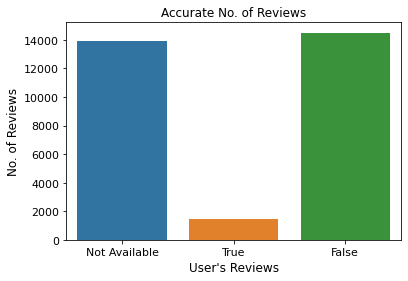

In [13]:
ax_plt = sns.countplot(df['reviews_didPurchase'])
ax_plt.set_xlabel(xlabel="User's Reviews",fontsize=12)
ax_plt.set_ylabel(ylabel='No. of Reviews',fontsize=12)
ax_plt.axes.set_title('Accurate No. of Reviews',fontsize=12)
ax_plt.tick_params(labelsize=11)

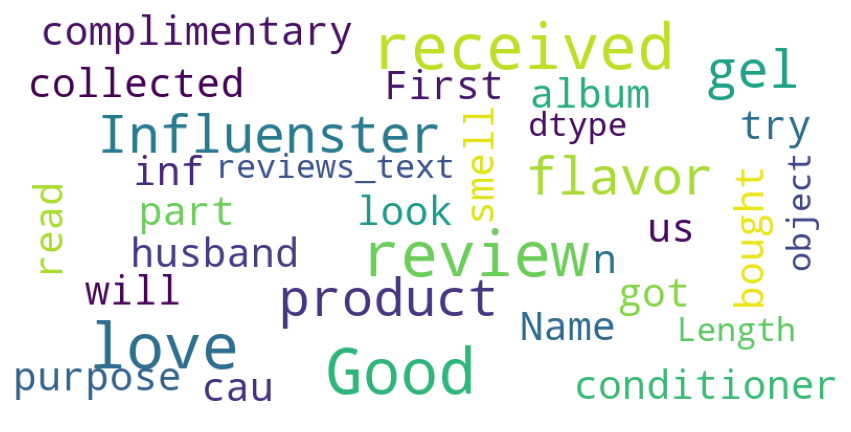

In [14]:
stopwords = set(STOPWORDS)
def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(df['reviews_text'])

In [15]:
data=df['reviews_text']
train_data=df['reviews_text']
y_target=df['reviews_rating'].map({1:'Unhappy',2:'Unhappy',3:'Ok',4:'Happy',5:'Happy'})

In [16]:
def preprocess(data, train_data):
    vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
    vectorize_word.fit(data)
    train_features_word = vectorize_word.transform(train_data)
    vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=50000)
    vectorize_char.fit(data)
    train_features_char = vectorize_char.transform(train_data)
    return hstack([train_features_char, train_features_word])

In [17]:
# vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
# vectorize_word.fit(data)
# train_features_word = vectorize_word.transform(train_data)

In [18]:
# vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=50000)
# vectorize_char.fit(data)
# train_features_char = vectorize_char.transform(train_data)
# train_features = hstack([train_features_char, train_features_word])

In [19]:
train_features = preprocess(data, train_data)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:497: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y_target,test_size=0.3,random_state=101,shuffle=True)

SVC Model:

In [21]:
lsvm = LinearSVC(class_weight='balanced')
l = lsvm.fit(X_train,y_train)

In [22]:
pred_test=l.predict(X_test)

In [23]:
unique, counts = np.unique(pred_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Happy' 8160]
 ['Ok' 329]
 ['Unhappy' 469]]


In [24]:
print("Accuracy Test : {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Test : 0.9285554811341817
              precision    recall  f1-score   support

       Happy       0.95      0.98      0.96      7979
          Ok       0.42      0.34      0.37       413
     Unhappy       0.84      0.69      0.76       566

    accuracy                           0.93      8958
   macro avg       0.74      0.67      0.70      8958
weighted avg       0.92      0.93      0.92      8958



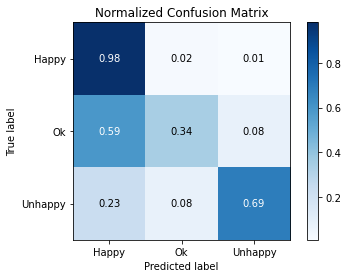

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)
plt.show()

Naive Bayes Classifier

In [26]:
mnb = MultinomialNB().fit(X_train, y_train)
pred_test = mnb.predict(X_test.todense())
print("Accuracy Test: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Test: 0.918508595668676
              precision    recall  f1-score   support

       Happy       0.93      0.99      0.96      7979
          Ok       0.44      0.02      0.04       413
     Unhappy       0.75      0.61      0.67       566

    accuracy                           0.92      8958
   macro avg       0.71      0.54      0.55      8958
weighted avg       0.89      0.92      0.90      8958



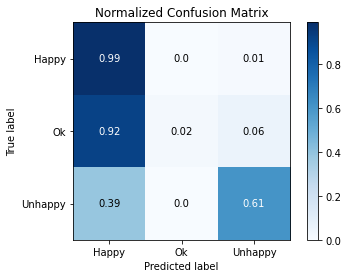

In [27]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)
plt.show()

XGB Classifier

In [28]:
xgb = XGBClassifier().fit(X_train, y_train)
pred_test = xgb.predict(X_test.todense())
print("Accuracy Test: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Test: 0.3453895958919402
              precision    recall  f1-score   support

       Happy       0.92      0.32      0.47      7979
          Ok       0.04      0.38      0.08       413
     Unhappy       0.14      0.70      0.24       566

    accuracy                           0.35      8958
   macro avg       0.37      0.47      0.26      8958
weighted avg       0.83      0.35      0.44      8958



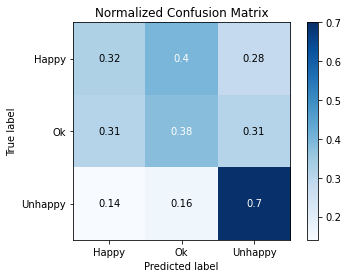

In [29]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)
plt.show()

Random Forest Classifier

In [30]:
rfc = RandomForestClassifier().fit(X_train, y_train)
pred_test = rfc.predict(X_test.todense())
print("Accuracy Test: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Test: 0.9273275284661755
              precision    recall  f1-score   support

       Happy       0.93      1.00      0.96      7979
          Ok       1.00      0.13      0.22       413
     Unhappy       0.95      0.51      0.66       566

    accuracy                           0.93      8958
   macro avg       0.96      0.54      0.61      8958
weighted avg       0.93      0.93      0.91      8958



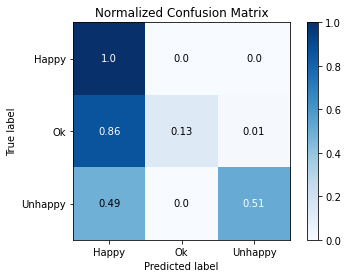

In [31]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)
plt.show()

As we can see, the best accuracy is from LogisticRegression model. Hence we will use the LR model for sentiment analysis.

In [32]:
# Save the model as a pickle in a file 
joblib.dump(lsvm, 'lr_model.pkl') 

['lr_model.pkl']

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from numpy import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

In [35]:
reviews = pd.read_csv('sample30.csv')
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [36]:
reviews = reviews.assign(uid=(reviews['name']).astype('category').cat.codes)

Dividing dataset into train and test

In [37]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(reviews, test_size=0.30, random_state=31)

In [38]:
print(train.shape)
print(test.shape)

(21000, 16)
(9000, 16)


In [39]:
df_pivot = train.reset_index().pivot_table(
    index='reviews_username',
    columns='uid',
    values='reviews_rating'
).fillna(0)

In [40]:
df_pivot.head(10)

uid,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,190,191,192,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,244,246,247,248,249,250,251,254,255,256,257,258,259,260,262,263,264,265,266,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Creating dummy train and dummy test dataset

In [41]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [42]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [43]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='uid',
    values='reviews_rating'
).fillna(1)

In [44]:
dummy_train.head()

uid,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,190,191,192,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,244,246,247,248,249,250,251,254,255,256,257,258,259,260,262,263,264,265,266,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

User Similarity Matrix

In [45]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [46]:
user_correlation.shape

(18252, 18252)

In [47]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='uid',
    values='reviews_rating'
)

In [48]:
df_pivot.head()

uid,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,190,191,192,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,244,246,247,248,249,250,251,254,255,256,257,258,259,260,262,263,264,265,266,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [49]:
# mean = np.nanmean(df_pivot, axis=1)
# df_subtracted = (df_pivot.T-mean).T

In [50]:
# df_subtracted.head()

In [51]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Prediction User-User

In [52]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [53]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  2.11709039,
         0.        ,  0.        ],
       [ 0.        ,  5.99634532,  0.        , ..., 12.7449399 ,
         0.        ,  0.70014004],
       [ 0.        , 22.08208143,  0.        , ..., 25.33289767,
         0.        ,  3.12347524],
       ...,
       [ 0.        ,  1.20338376,  0.        , ..., 17.61197098,
         2.32119173,  0.        ],
       [ 0.        ,  1.20338376,  0.        , ..., 17.61197098,
         2.32119173,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  5.43918224,
         5.65478568,  0.        ]])

In [54]:
user_predicted_ratings.shape

(18252, 252)

In [55]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

uid,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,190,191,192,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,244,246,247,248,249,250,251,254,255,256,257,258,259,260,262,263,264,265,266,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.321192,0.0,0.0,0.0,0.000000,0.000000,2.279804,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.117090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,3.123475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.136757,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,4.396894,0.000000,0.0,0.0,0.000000,0.00000,2.321192,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.117090,1.856953,0.0,0.000000,0.0,0.0,2.051823,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.321192,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.423418,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.552533,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.117090,0.000000,0.000000
00sab00,0.0,5.996345,0.0,0.0,0.0,0.0,0.0,0.0,11.622748,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,2.097953,0.0,0.0,1.278595,0.0,0.0,2.09657,0.0,1.697056,0.0,1.713412,0.255719,0.0,5.555348,0.521286,0.0,0.000000,2.500000,0.000000,7.959230,0.0,0.0,0.0,0.000000,0.000000,5.410181,1.305582,0.0,1.189296,0.000000,0.000000,0.0,0.000000,4.381075,4.396894,4.847889,1.568640,0.000000,0.0,0.0,6.154816,25.132506,25.660370,0.0,0.000000,0.0,0.0,0.0,11.452702,0.0,0.0,2.620712,0.000000,8.747444,2.649065,0.0,0.000000,0.0,0.0,0.0,0.0,2.4,0.0,0.731437,0.0,0.0,0.0,0.0,0.0,94.976061,0.0,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445435,0.0,0.0,1.927588,3.802401,0.0,2.227177,0.000000,0.00000,0.0,10.989914,0.0,0.000000,2.461830,1.249390,0.700140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.535534,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3.438266,1.927588,1.278595,0.0,0.0,0.000000,1.568640,0.0,0.0,0.000000,0.00000,50.483545,0.0,0.0,1.568640,0.0,0.0,0.0,2.097953,0.000000,2.325893,0.000000,0.0,9.112821,0.0,0.000000,2.390457,0.000000,0.0,0.0,2.117090,6.689523,0.0,0.000000,0.0,0.0,45.336191,0.0,1.777778,0.0,0.000000,0.0,1.305582,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,3.376232,21.043676,0.0,0.0,0.00000,0.0

In [56]:
# Take the user ID as input.
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: abigail
abigail


In [57]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

uid
64     14.463967
93     12.412134
65      8.638465
239     7.968471
178     6.550351
151     6.154816
244     4.226820
157     3.721681
183     3.355309
152     3.254723
73      3.054236
55      2.828427
41      2.400000
268     2.302786
57      2.117090
176     2.117090
107     1.952834
38      1.831858
128     1.831858
166     1.407247
Name: abigail, dtype: float64

In [58]:
products = pd.DataFrame(data=reviews[['uid', 'name']])
products.drop_duplicates(inplace=True)
products

,uid,name
0,182,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,140,Lundberg Organic Cinnamon Toast Rice Cakes
3,120,K-Y Love Sensuality Pleasure Gel
30,112,"J.R. Watkins Hand Cream, Lemon Cream"
36,11,Ambi Complexion Cleansing Bar
40,117,"Johnson's Baby Bubble Bath and Wash, 15oz"
54,171,Olay Regenerist Deep Hydration Regenerating Cream
688,268,Windex Original Glass Cleaner Refill 67.6oz (2...
1036,99,"Heinz Tomato Ketchup, 38oz"
1037,124,Kind Dark Chocolate Chunk Gluten Free Granola ...


In [59]:
d = pd.merge(d,products,left_on='uid',right_on='uid', how = 'left')
d.head()

,uid,abigail,name
0,64,14.463967,Clorox Disinfecting Bathroom Cleaner
1,93,12.412134,Godzilla 3d Includes Digital Copy Ultraviolet ...
2,65,8.638465,Clorox Disinfecting Wipes Value Pack Scented 1...
3,239,7.968471,The Resident Evil Collection 5 Discs (blu-Ray)
4,178,6.550351,"Pendaflex174 Divide It Up File Folder, Multi S..."


Evaluation - User User

In [60]:
common = test[test['reviews_username'].isin(train['reviews_username'])]
common.shape

(2049, 16)

In [61]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,uid
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive,228
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,NaN,NaN,kasheville,Positive,17
15098,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-11T00:00:00.000Z,NaN,True,5,"Wow, what a difference ease makes. Thanks for ...",Best Ever,NaN,NaN,arlene,Positive,19
17968,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29T00:00:00.000Z,False,True,5,Love this product. Its amazing. Made my lips s...,wonderful,NaN,NaN,mimi3,Positive,257
28020,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-05-20T00:00:00.000Z,NaN,True,5,This movie is wonderful. It has a great story ...,Great Family Movie,NaN,NaN,movielover,Positive,183


In [62]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='uid', values='reviews_rating')

In [63]:
user_correlation_df = pd.DataFrame(user_correlation)

In [64]:
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,...,17753,17754,17755,17756,17757,17758,17759,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17778,17779,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789,17790,17791,17792,17793,17794,17795,17796,17797,17798,17799,17800,17801,17802,17803,17804,17805,17806,17807,17808,17809,17810,17811,17812,17813,17814,17815,17816,17817,17818,17819,17820,17821,17822,17823,17824,17825,17826,17827,17828,17829,17830,17831,17832,17833,17834,17835,17836,17837,17838,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848,17849,17850,17851,17852,17853,17854,17855,17856,17857,17858,17859,17860,17861,17862,17863,17864,17865,17866,17867,17868,17869,17870,17871,17872,17873,17874,17875,17876,17877,17878,17879,17880,17881,17882,17883,17884,17885,17886,17887,17888,17889,17890,17891,17892,17893,17894,17895,17896,17897,17898,17899,17900,17901,17902,17903,17904,17905,17906,17907,17908,17909,17910,17911,17912,17913,17914,17915,17916,17917,17918,17919,17920,17921,17922,17923,17924,17925,17926,17927,17928,17929,17930,17931,17932,17933,17934,17935,17936,17937,17938,17939,17940,17941,17942,17943,17944,17945,17946,17947,17948,17949,17950,17951,17952,17953,17954,17955,17956,17957,17958,17959,17960,17961,17962,17963,17964,17965,17966,17967,17968,17969,17970,17971,17972,17973,17974,17975,17976,17977,17978,17979,17980,17981,17982,17983,17984,17985,17986,17987,17988,17989,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,181

In [65]:
common.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,uid
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive,228


In [66]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [67]:
user_correlation_df_1.shape

(1728, 18252)

In [68]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [69]:
user_correlation_df_3 = user_correlation_df_2.T

In [70]:
user_correlation_df_3.head()

,00sab00,1234,1234asdf,123charlie,1943,4cloroxl,4djs,7inthenest,85lisa,a hutch,aalyah,aaron,abbey,abc,abcgator,abigail,abismomy,ace24,acellacey,acg1,aclass,actionaction,adam,adamsmom,adizzione,adma2,adriana9999,ael26,afwifey2003,agmt,ah78,aisha,aj,aj1135,ajackson75,ajay,akesler19,akhan,alena125,alex,ali1353,allison33,ally,ally1989,allyj1984,alredhouse,aluns,amanda,amanda01,amandalynn,amandarose,amber0528,ambybambi0725,amerbamer,amgo2,ami35,amlyke,amor,amsmes26,amy00381,amy1,amy75,amyrn,anas79,anatnas4,andie,andrea,andream82,andrew,andy,ang32,angel,angela,angelbabee1965,angie,angie0104,angie2,angiesmessykids,ann222,anna,annie,annieb,anyab,aphoung,april,aprilg87,aprilrdh,aria,arlene,arlingtondonna,arob,artlile,aryalynn,as123,ash1,ash4,ashleyfawne,ashsmash,athenabear,atid,autumn,awesome,awesomesunshine,ayterrazas,azamy,babs,babumsky,babygirl,badgrl3616,badhairbob,bailee,baker,bakie,bambi,bams,bananakitty,barb,barb24,barber226,bargainhuntergmaoftwo,bargainshopper,barryjh,bas56,batts,bb902460,bbbb,bbjj,bblack,bbshopper,bean,bearyshopper2,beaterman,beavis,becca,beccaruth,becky,becky75,beebee,beechetu,beezy,bella,belovely,berly,berreca,bert,bestbuyshopper,beth74,beth7557,betsy,betty,bhemp,bhere4u,bhiam,bigb,bigred,bigredd,bill,bjhoneybear,bkenyon,blaine,bleachqueen,blindsay,blondie,blt66,blue,blue91,bluebox,bluefox,blurunner,bluu,bnspirit,bob,bobb,bobby,bobo,bonbon,bongojack,booboo,boomer,bostonmommy,bowbow,bpii,brad,brady,brandon,brandy,brandy33,breezy,bren,brett,breyoke,bri_tairi,brian,brittany,brittneezy,brookieboo1994,brownshuga40,bruce,bryan,btechthor,bubbasmom,bubblegum197035,bubbs33,bubby,buckeye,bullhorn,bumblebee0513,bunny,burntkneechin,burntpopcorn,buster,busybee1995,busymama123456,busymom12,buttercup,byamazon customer,bybarbara edwards,bydave,byfinzin,byjennifer,bykindle customer,bylynn,c1a5,cabello,cadydid,cait,cally,cami,canela2,cangel83,cannon,canyons422,capnscrummy,captainkc,carbennett,carls,carol,carol1102,carolynrk,carrie,carrieletti,carsonensley,casey8924,cass,cassandra,cassieh,cate nicole,cath,catherine4155,cathy,cathy123,cbennett,cburt,ccccc,cdedbdb,cecie,cecy89,cgranados,changeisdemanded,channybabygirl,char,charles,charlie,charvey,chas,chasesmommy9810,chattycathy01,chelle30,chellington,chels,chels3293,chels818,cheryl,chey,chicagojessica,chick1975,chicosbrat6,chief,chilli,chinarachel,chips,chris,chrisdo,chrissy,chrissyinky,christi1982,christina1001,christina429usc,christine,christine68,chrystal1101,chuck,cindy,cindy1834,cindy95,cindyt,cj,cjhays,cjsmom,clair,cleanenoughformoms,cleaner mom,cleaner4,cleaning123,cleaninglady30,cleanmachine,cleo,clnhse,cloroxfan12,cloroxfan1983,cloroxfool,clubpeck,cly8,cmerck2006,cmj1,cmorgan,cmpchrissy,coachlynn,coffey08,cole,connie,connie36,cookie,cookie0258,cookiemonster,cool,coopsmom,coronanatalie,coscat,cougs,countprice,couponblue27,couponcara,coupongoddess1983,couponingmo,couponmama,coupons2get,couponsavvychick,courtney,courts,cowboy,cowgirl,cozygirl,cragerater,crazycook4,crdbls,creaturee2,cricket,crissyterrio,cristalr,critiquethis,crittbo,crl59,crsgin,cry12,crystal132,crysv,cubby,cuevas305,curly lee,curlytea,customdave,cutemommyiam,cw06,cyberta,cyndi,cyndy,cynthia49,daddypanda00,dadof2b1g,daisymae19,dale,damanda,dana,danas,dancemom91,daner,daniel,daniela magallanes,daniella23,danielle,danitotheelle,danl,danm,danny,daredevil,darkaran1,dave,david,david0858,david1,dawn,dawnrose1,dbarne13,dbcrum,dcgirlval,ddubi1,deb,deb1023,deb55,debbie,debbie1032,debbie54,debby13,debi,debi49,dee,dee1,dee2,deedee0614,deedee88,deef,delias00,denise,denisem,desi03,desirae,detets,devydev,diana,diane,diddy,diem,dillyn,dima,dinak001,dino,dishguy,disneyfan,divya,dizzle,djman559,djx1977,dkane514,dkhall85,dls77,dmgeary,dmommy,dolly,doloresnyc,donna,donnap,donny304,dontdodat,doodlebug,doreen,dorita,dorothy1026,dorty,doug,dpatch,dr love,drabo,draya77,drc2,dre4,drea,dreamer79,drew,ds2014,dto2865,dts976,duke,dukefan1979,dusty,dvdfan,dylan21,dylansmom,e8181,earreaga,eastrauss,easy,eclausen91,ecyoung105,eddie,edie

In [71]:
user_correlation_df_3.shape

(1728, 1728)

In [72]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 2.12132034,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.1821789 ,  0.        ,  0.        , ...,  0.        ,
         0.33805752,  0.        ],
       [11.72793939,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [73]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='uid', values='reviews_rating').fillna(0)

In [74]:
dummy_test.shape

(1728, 126)

In [75]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [76]:
common_user_predicted_ratings.head(2)

uid,1,4,9,10,14,15,17,19,20,21,24,26,29,30,31,33,38,39,41,47,48,49,52,53,55,56,57,58,60,63,64,65,71,75,76,79,81,82,84,87,89,91,93,96,97,104,105,107,108,115,117,118,119,120,121,123,124,125,128,129,131,133,136,139,141,142,143,144,151,153,154,155,157,158,160,161,163,164,165,166,168,169,171,173,176,178,183,185,186,187,191,193,198,199,200,201,202,205,206,212,220,221,222,227,228,230,232,237,238,239,240,241,242,244,245,251,253,254,256,257,258,260,263,264,268,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,46.991606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.4722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.101457,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [78]:
common_ = common.pivot_table(index='reviews_username', columns='uid', values='reviews_rating')

In [79]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [80]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.144437398262909


## Item based Similarity

In [81]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='uid',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,1421nikki,143st,148maine,1515,15425shopper,170361eggs,18612,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1cadet,1chynna,1cleaner,1friendlycat,1gamer,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jc1,1jodie,1kindword,1officegal,1scooby1,1shop,1sonny,1stcavdivision,1stlady,1sttimemama,1sungirl,1tomg,1vgarcia,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2016,2062351337,20crafter16,21honey,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2689,2big,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2ds4es14,2esinapod,2go4savings,2hearts1love,2low4zero,2rogersmakearight,2thumbsup,2w0cat5z,2xmom,30103,3276teev,3375509742,370gt,37f5p,38redsox,3babiesat41,3bear,3boys2turtles5chicks,3card,3dfan,3dknights,3dmoviewatcher,3dpic,3lilones,3littleswimmers,3ringbandb,3sawhorsesneeded,3scissors,3skyyblue,4048197640,4112,4141,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4littleones,4luds,4my5goldens,4shop,4stew57,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,57susie,5alarm,5boysohmy,5zenuff,66babe,66cutie,6787249844,67firebird,69chopper,6cockers,6mex2,6utefans,7,7.87E+11,70chp,714reginald,714rv,72443,74corvetteguy,7737593842,79captm79,7autumn5,7inthenest,7of9,8.84E+11,80021mom,80204,8023,808wrx,81t21,827,85721747267,8574178605,85lisa,8675309,89c46698305f04e39d57a88a2c5c3ce297787288,8ellie24,8kucs,8mooshu,8rob1,8sk8anddon8,8thred,9373weld,987654321abc,98nd500,99runner,a hutch,a leaf on the family tree,a1126,a11mxdup,a1s3,a77077,a786,a7xmaddlove,aabrannon,aac06002,aac3,aagbaghagmom,aalyah,aaron,aaronm,aaube1990,aaulvu,aayla,ab45,ababe,abacadaba,abananie,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abbi,abbs77,abbuyguy,abby,abby1,abby132,abby8992,abbysmama,abc,abc1245,abc3,abcd,abcdefghij,abcgator,abd1,abear93,abel9027,abelc,abeverly7,abg0821,abi09,abigail,abigailc,abihaven,abismomy,abm27,abmurals,about2bmom,abphillips7858,abqdavenm,abret,abrildiez,abruscini,abuelita,abyo,ac228,ac90,ac94,acadia,acarrera9461,acasabel,accounting m,accwiz,ace1183,ace2,ace22,ace24,acegamer,acehardware,acellacey,acer,aces,acetolman,acf11154,acg1,achick,achkosh,ackk,aclass,acleanerworld,acmillion,acr2015,acs614,actias,action,actionaction,actionaddict,actiond,actionjem,activegal,acts1123,acurbrider,acv4217,ada_us_ohpiiy,adaizy79,adam,adam1977,adamofh,adams31,adamsmom,adamsra10,adan,adapters,adash75,adballgator,addie,addieb87,addmotherhood25,addto the 2nd degree,adele,adeleforlife,adeline,ades,adina,adizzione,adma2,adman,admbat,admin girl,admin164,adminpro,adonis,adr1ana,adr2,adrbeach,adrbeach27,adrialc,adrian17,adriana,adriana9999,adrianadad,adrid,adrienne,adub,adub0222,aduffy,advichiel,adw123,adynsmom,adysonkate,aebw volunteer,aechking,aeh1021,aeharris,aehr,ael26,aeroflux,aeroperu,aet39641,afair77,afhaffner,afilii,afwifey2003,ag1987,agamu16,agard617,age7,agent4678,agentcat,agentpaper,aggielily05,agibby722,agmt,agopy19,agreenlee86,ah78,ah87,aharbin88,ahaschart,ahawk,aheadfullofdreams,ahjohnson1983,ahmedsat,ahoy,aidnel646,aileen2,aim1,aimcoop,aimee,aira,airborne2,airborneannie,airkingchris,aiscoupon,aisha,aiyana84,aj,aj0324,aj1135,aj2012,aj345,aj792008,aj96,ajackson75,ajandjen,ajay,ajay1,ajeff,ajf9597,ajface24,ajgreer1979,ajh2298,ajhobb07,aji28,ajinak,ajinfl,ajkw,ajmac2000,ajmv9,ajoiwejsd,ajpowell,ajr1,ajrecr,ajskot,ajsmom,ajune,ajv2,ajvi1201,ajzookie,ak04,akathb,akbluemeanie,akcrazymom15,akeane1228,akesler19,aketch,akeyes77,akghwe,akgirl,akgrl,akhan,akimom,akintola10,akipanda,akjones,akmom,akpaz81885,akporter84,aktar,aktcharlotte,al,al0000,al09,al31,al33,al5435,al60,alaarie,alabamaroberts,alamo99,alan,aland,alanlee,alansmithee,alapi,alarm

In [82]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [83]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,1421nikki,143st,148maine,1515,15425shopper,170361eggs,18612,1943,1950rmm,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1cadet,1chynna,1cleaner,1friendlycat,1gamer,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jc1,1jodie,1kindword,1officegal,1scooby1,1shop,1sonny,1stcavdivision,1stlady,1sttimemama,1sungirl,1tomg,1vgarcia,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2016,2062351337,20crafter16,21honey,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2689,2big,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2ds4es14,2esinapod,2go4savings,2hearts1love,2low4zero,2rogersmakearight,2thumbsup,2w0cat5z,2xmom,30103,3276teev,3375509742,370gt,37f5p,38redsox,3babiesat41,3bear,3boys2turtles5chicks,3card,3dfan,3dknights,3dmoviewatcher,3dpic,3lilones,3littleswimmers,3ringbandb,3sawhorsesneeded,3scissors,3skyyblue,4048197640,4112,4141,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,49ersfor6,4bukfam,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4littleones,4luds,4my5goldens,4shop,4stew57,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,57susie,5alarm,5boysohmy,5zenuff,66babe,66cutie,6787249844,67firebird,69chopper,6cockers,6mex2,6utefans,7,7.87E+11,70chp,714reginald,714rv,72443,74corvetteguy,7737593842,79captm79,7autumn5,7inthenest,7of9,8.84E+11,80021mom,80204,8023,808wrx,81t21,827,85721747267,8574178605,85lisa,8675309,89c46698305f04e39d57a88a2c5c3ce297787288,8ellie24,8kucs,8mooshu,8rob1,8sk8anddon8,8thred,9373weld,987654321abc,98nd500,99runner,a hutch,a leaf on the family tree,a1126,a11mxdup,a1s3,a77077,a786,a7xmaddlove,aabrannon,aac06002,aac3,aagbaghagmom,aalyah,aaron,aaronm,aaube1990,aaulvu,aayla,ab45,ababe,abacadaba,abananie,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abbi,abbs77,abbuyguy,abby,abby1,abby132,abby8992,abbysmama,abc,abc1245,abc3,abcd,abcdefghij,abcgator,abd1,abear93,abel9027,abelc,abeverly7,abg0821,abi09,abigail,abigailc,abihaven,abismomy,abm27,abmurals,about2bmom,abphillips7858,abqdavenm,abret,abrildiez,abruscini,abuelita,abyo,ac228,ac90,ac94,acadia,acarrera9461,acasabel,accounting m,accwiz,ace1183,ace2,ace22,ace24,acegamer,acehardware,acellacey,acer,aces,acetolman,acf11154,acg1,achick,achkosh,ackk,aclass,acleanerworld,acmillion,acr2015,acs614,actias,action,actionaction,actionaddict,actiond,actionjem,activegal,acts1123,acurbrider,acv4217,ada_us_ohpiiy,adaizy79,adam,adam1977,adamofh,adams31,adamsmom,adamsra10,adan,adapters,adash75,adballgator,addie,addieb87,addmotherhood25,addto the 2nd degree,adele,adeleforlife,adeline,ades,adina,adizzione,adma2,adman,admbat,admin girl,admin164,adminpro,adonis,adr1ana,adr2,adrbeach,adrbeach27,adrialc,adrian17,adriana,adriana9999,adrianadad,adrid,adrienne,adub,adub0222,aduffy,advichiel,adw123,adynsmom,adysonkate,aebw volunteer,aechking,aeh1021,aeharris,aehr,ael26,aeroflux,aeroperu,aet39641,afair77,afhaffner,afilii,afwifey2003,ag1987,agamu16,agard617,age7,agent4678,agentcat,agentpaper,aggielily05,agibby722,agmt,agopy19,agreenlee86,ah78,ah87,aharbin88,ahaschart,ahawk,aheadfullofdreams,ahjohnson1983,ahmedsat,ahoy,aidnel646,aileen2,aim1,aimcoop,aimee,aira,airborne2,airborneannie,airkingchris,aiscoupon,aisha,aiyana84,aj,aj0324,aj1135,aj2012,aj345,aj792008,aj96,ajackson75,ajandjen,ajay,ajay1,ajeff,ajf9597,ajface24,ajgreer1979,ajh2298,ajhobb07,aji28,ajinak,ajinfl,ajkw,ajmac2000,ajmv9,ajoiwejsd,ajpowell,ajr1,ajrecr,ajskot,ajsmom,ajune,ajv2,ajvi1201,ajzookie,ak04,akathb,akbluemeanie,akcrazymom15,akeane1228,akesler19,aketch,akeyes77,akghwe,akgirl,akgrl,akhan,akimom,akintola10,akipanda,akjones,akmom,akpaz81885,akporter84,aktar,aktcharlotte,al,al0000,al09,al31,al33,al5435,al60,alaarie,alabamaroberts,alamo99,alan,aland,alanlee,alansmithee,alapi,alarm

In [84]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00657044  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00657044  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [85]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [86]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.02352264, 0.        ,
        0.        ],
       [0.        , 0.00117139, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04848007, 0.        , ..., 0.        , 0.        ,
        0.00338607],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00062229, 0.00063779,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00155571, 0.00159447,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03252811, 0.02124867,
        0.        ]])

In [87]:
item_predicted_ratings.shape

(18252, 252)

In [88]:
dummy_train.shape

(18252, 252)

In [89]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

uid,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,190,191,192,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,244,246,247,248,249,250,251,254,255,256,257,258,259,260,262,263,264,265,266,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.009713,0.0,0.0,0.0,0.0,0.0,0.032621,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.049164,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.042692,0.000000,0.0,0.0,0.000000,0.0,0.017402,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.041993,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.049792,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.023523,0.000000,0.000000
00sab00,0.0,0.001171,0.0,0.0,0.0,0.0,0.0,0.0,0.003316,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000712,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.011828,0.0,0.000000,0.000253,0.0,0.000000,0.000000,0.0,0.000000,0.001182,0.0,0.000181,0.0,0.0,0.0,0.0,0.0,0.003270,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.006705,0.010673,0.005909,0.014686,0.0,0.0,0.0,0.000718,0.000000,0.00004,0.0,0.0,0.0,0.0,0.0,0.00902,0.0,0.0,0.003168,0.0,0.003836,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.003959,0.0,0.000253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000434,0.003829,0.0,0.007152,0.0,0.0,0.0,0.010139,0.0,0.0,0.0,0.000106,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001380,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.005018,0.000573,0.000000,0.0,0.0,0.000000,0.004965,0.0,0.0,0.000000,0.0,0.000402,0.0,0.0,0.0,0.0,0.0,0.0,0.005299,0.000000,0.002636,0.0,0.0,0.008,0.0,0.0,0.00000,0.000000,0.0,0.0,0.002546,0.000000,0.0,0.0,0.0,0.0,0.007844,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.002826,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.002124,0.000000,0.0,0.0,0.0,0.0,0.005220,0.00444,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.002880,0.0,0.000000,0.001287,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000

In [90]:
# Take the user ID as input
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: 01impala
01impala


In [91]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

uid
56     0.121329
172    0.107870
255    0.075997
183    0.052110
1      0.048480
165    0.040144
211    0.035352
115    0.033211
63     0.026446
59     0.020410
157    0.015445
9      0.014725
34     0.012757
120    0.012445
48     0.011906
205    0.010845
133    0.009448
244    0.008663
146    0.008301
58     0.008153
Name: 01impala, dtype: float64

In [92]:
d = pd.merge(d,products,left_on='uid',right_on='uid',how = 'left')
d.head()

,uid,01impala,name
0,56,0.121329,Chester's Cheese Flavored Puffcorn Snacks
1,172,0.107870,Olivella Bar Soap - 3.52 Oz
2,255,0.075997,Various Artists - Choo Choo Soul (cd)
3,183,0.052110,Planes: Fire Rescue (2 Discs) (includes Digita...
4,1,0.048480,100:Complete First Season (blu-Ray)


In [93]:
train_new = pd.merge(train,products,left_on='uid',right_on='uid',how='left')
train_new[train_new.reviews_username == 'mike'] .head()

,id,brand,categories,manufacturer,name_x,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,uid,name_y
600,AVpfE7puilAPnD_xUcCW,South Shore,"Furniture,Bedroom Furniture,Nightstands,Home,H...",South Shore,Bilbao Nightstand Gray Oak - South Shore,2014-12-20T00:00:00Z,NaN,NaN,1,1) This product was missing pieces. Not screws...,Horrible construction,NaN,NaN,mike,Positive,31,Bilbao Nightstand Gray Oak - South Shore
2017,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-02-05T00:00:00.000Z,NaN,True,5,My kids (and I) had a great time watching this...,Very nice kids movie,NaN,NaN,mike,Positive,183,Planes: Fire Rescue (2 Discs) (includes Digita...
2805,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),2016-12-03T00:00:00.000Z,NaN,True,5,I saw this in the theatre and found it to be h...,Extremely funny movie!,NaN,NaN,mike,Negative,151,Mike Dave Need Wedding Dates (dvd + Digital)
3313,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-10-17T00:00:00.000Z,NaN,True,5,Awesome movie! My son has been watching on rep...,awesome movie!!,NaN,NaN,mike,Positive,93,Godzilla 3d Includes Digital Copy Ultraviolet ...
3394,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2017-01-16T00:00:00.000Z,NaN,True,5,"I liked Godzilla a lot, the computer graphics ...",A great movie,NaN,NaN,mike,Positive,93,Godzilla 3d Includes Digital Copy Ultraviolet ...


Evaluation - Item Item

In [94]:
test.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment', 'uid'],
      dtype='object')

In [95]:
common =  test[test.uid.isin(train.uid)]
common.shape

(8978, 16)

In [96]:
common.head(4)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,uid
4332,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-09-10T00:00:00.000Z,False,True,5,I've only owned this product for 4 weeks so co...,Great buy,NaN,NaN,sansname,Positive,107
3434,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Condi...,2016-04-08T00:00:00.000Z,False,NaN,5,This is thick stuff! I was surprised by the co...,Serious conditioning!,NaN,NaN,jennypstrong,Positive,176
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive,228
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,NaN,NaN,kasheville,Positive,17


In [97]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='uid', values='reviews_rating').T

In [98]:
common_item_based_matrix.shape

(199, 8371)

In [99]:
item_correlation_df = pd.DataFrame(item_correlation)

In [100]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
item_correlation_df['uid'] = df_subtracted.index
item_correlation_df.set_index('uid',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09074,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09074,0.0,0.0,0.0,0.0,0.0,0.01616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001171,0.0,0.0,0.0,0.006781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [102]:
list_name = common.uid.tolist()

In [103]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [104]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [105]:
item_correlation_df_3.head()

,0,1,5,7,8,9,10,13,14,15,16,17,19,20,21,22,25,26,27,28,29,30,31,32,33,34,38,39,40,41,42,44,47,48,49,51,52,53,54,55,56,57,58,60,62,63,64,65,68,69,70,71,73,74,75,76,77,78,79,81,82,84,87,88,89,90,91,93,95,96,97,98,100,104,105,106,107,108,111,112,113,115,116,117,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,135,136,139,141,142,143,144,145,146,147,148,149,150,151,153,154,155,156,157,158,159,160,161,163,164,165,166,168,169,171,172,173,175,176,178,179,180,181,183,185,186,187,188,190,191,192,194,196,197,198,199,200,201,202,204,205,206,211,212,213,214,217,219,220,221,222,224,225,226,227,228,230,232,233,235,236,237,238,239,240,241,242,244,246,247,249,250,251,254,255,256,257,258,260,263,264,266,268,269,270
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.027487,0.0,0.0,0.0,0.0,0.0,0.0,0.013841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09074,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003089,0.0,0.0,0.0,0.0,0.0,0.0,0.09074,0.0,0.0,0.0,0.0,0.01616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001171,0.0,0.0,0.006781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,

In [106]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08080011, 0.06464009, ..., 0.01395515, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01951687, 0.        , 0.        , ..., 0.        , 0.00155571,
        0.00124457],
       [0.0127492 , 0.        , 0.        , ..., 0.        , 0.00159447,
        0.00127557],
       [0.        , 0.00564345, 0.00451476, ..., 0.        , 0.        ,
        0.        ]])

In [107]:
common_item_predicted_ratings.shape

(199, 8371)

In [108]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='uid', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [109]:
common_ = common.pivot_table(index='reviews_username', columns='uid', values='reviews_rating').T

In [110]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


D:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [111]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [112]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5609275226619865


Hence we will be using User User Prediction

In [113]:
sentiment_analysis_model = joblib.load('lr_model.pkl')

In [114]:
user = input('User name: ')

User name: mike


In [115]:
joblib.dump(user_final_rating, 'recommendation_model.pkl') 

['recommendation_model.pkl']

In [116]:
recommendation20 = user_final_rating.loc[user].sort_values(ascending=False)[0:20]

In [117]:
recommendation20

uid
64     413.814732
239     70.471263
157     60.783193
200     36.443705
244     24.578236
268     21.028309
178     19.031412
41      18.856538
108     14.543076
71      13.520268
76      12.261800
230      9.932752
63       8.997576
33       8.638143
166      8.531504
107      7.964874
48       7.919102
9        7.914414
58       7.455315
119      5.927806
Name: mike, dtype: float64

In [118]:
recommendation20 = products[products.uid.isin(recommendation20.index)]

In [119]:
recommendation20

,uid,name
688,268,Windex Original Glass Cleaner Refill 67.6oz (2...
1537,76,Dark Shadows (includes Digital Copy) (ultravio...
2583,157,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
3790,178,"Pendaflex174 Divide It Up File Folder, Multi S..."
4131,107,Hoover174 Platinum Collection153 Lightweight B...
4531,239,The Resident Evil Collection 5 Discs (blu-Ray)
5591,200,Red (special Edition) (dvdvideo)
6263,108,"Hormel Chili, No Beans"
15739,41,"Burt's Bees Lip Shimmer, Raisin"
17309,119,Just For Men Touch Of Gray Gray Hair Treatment...


In [120]:
recommendation20_df = pd.DataFrame({'productId':recommendation20.uid, 'name': recommendation20.name})

In [121]:
recommendation20_df.head(20)

,productId,name
688,268,Windex Original Glass Cleaner Refill 67.6oz (2...
1537,76,Dark Shadows (includes Digital Copy) (ultravio...
2583,157,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
3790,178,"Pendaflex174 Divide It Up File Folder, Multi S..."
4131,107,Hoover174 Platinum Collection153 Lightweight B...
4531,239,The Resident Evil Collection 5 Discs (blu-Ray)
5591,200,Red (special Edition) (dvdvideo)
6263,108,"Hormel Chili, No Beans"
15739,41,"Burt's Bees Lip Shimmer, Raisin"
17309,119,Just For Men Touch Of Gray Gray Hair Treatment...


In [122]:
recommendation20reviews = reviews[reviews.uid.isin(recommendation20_df.productId)]

In [123]:
data = recommendation20reviews['reviews_text']
train_data = recommendation20reviews['reviews_text']

In [124]:
vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
train_features_word = vectorize_word.fit_transform(data)

In [125]:
train_features_word.shape

(8832, 9456)

In [126]:
vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=60000)
train_features_char = vectorize_char.fit_transform(data)
# train_features = hstack([train_features_char, train_features_word])

In [127]:
train_features_char.shape

(8832, 60000)

In [128]:
train_features_car = hstack([train_features_char, train_features_word])

In [129]:
train_features_char.shape

(8832, 60000)

In [130]:
result = sentiment_analysis_model.predict(train_features_char)

In [131]:
result

array(['Happy', 'Happy', 'Happy', ..., 'Happy', 'Happy', 'Happy'],
      dtype=object)

In [132]:
recommendation20_df = recommendation20_df.join(pd.DataFrame({'sentiment':result}))

In [133]:
recommendation20_df[recommendation20_df['sentiment'] == 'Happy']['name'][0:5]

688     Windex Original Glass Cleaner Refill 67.6oz (2...
1537    Dark Shadows (includes Digital Copy) (ultravio...
2583    My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
3790    Pendaflex174 Divide It Up File Folder, Multi S...
4131    Hoover174 Platinum Collection153 Lightweight B...
Name: name, dtype: object